In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import sys
sys.path.append("../../../../src/")
import tunneling

from scipy.optimize import curve_fit
plt.style.use(["science","bright","grid"])

In [6]:
# Parameter and Inti
N_x, N_y, N_z       = 9,9,1
electrode_pos       = [[0,0,0],[int((N_x-1)/2),0,0],[N_x-1,0,0],
                       [0,int((N_y-1)/2),0],[0,N_y-1,0],[N_x-1,int((N_y)/2),0],
                       [int((N_x)/2),(N_y-1),0],[N_x-1,N_y-1,0]]
electrode_type      = ['constant']*len(electrode_pos)
radius, radius_std  = 10.0, 0.0
eps_r, eps_s        = 2.6, 3.9
lattice             = tunneling.tunnel_class(electrode_type)

# Build Network and attach Electrodes
lattice.cubic_network(N_x, N_y, N_z)
lattice.set_electrodes_based_on_pos(electrode_pos, N_x, N_y)
# lattice.add_np_to_output()
lattice.init_nanoparticle_radius(radius, radius_std)
# lattice.update_nanoparticle_radius()
lattice.pack_planar_circles()
lattice.init_adv_indices()

In [18]:
N_p, N_e = lattice.N_particles, lattice.N_electrodes
src, tgt = lattice.return_advanced_indices()
r_vals   = np.repeat(251e6, len(src))

In [23]:
def build_conductance_matrix(source, target, R, N_p, N_e):

    n_nodes = N_p + N_e
    Y       = np.zeros((n_nodes, n_nodes),dtype=float)

    for i, j, R_val in zip(source,target,R):
        
        g       = 1.0/R_val
        Y[i,j]  -= g
        Y[i,i]  += g

    return Y

Y = build_conductance_matrix(src, tgt, r_vals, N_p, N_e)
print("Conductance Matrix\n",Y)

Conductance Matrix
 [[ 3.98406375e-09  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.98406375e-09  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.98406375e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.19521912e-08
  -3.98406375e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.98406375e-09
   1.19521912e-08 -3.98406375e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.98406375e-09  1.19521912e-08]]


In [28]:
def transfer_coeffs(Y, N_p, N_e, out_idx):
    n_nodes = N_p + N_e
    u_idx   = np.arange(N_e, n_nodes)
    k_idx   = np.arange(N_e)

    Y_uu = Y[np.ix_(u_idx, u_idx)]
    Y_uk = Y[np.ix_(u_idx, k_idx)]

    # Precompute: A = -Y_uu^{-1} Y_uk
    inv_Yuu = np.linalg.inv(Y_uu)
    A       = -inv_Yuu @ Y_uk  # (N_p, N_e)

    # Current into output electrode for 1 V at each electrode
    Y_out_k     = Y[out_idx, k_idx]
    Y_out_u     = Y[out_idx, u_idx]
    indirect    = Y_out_u @ A  # shape (N_e,)
    G           = -Y_out_k - indirect

    # Output electrode always has zero self-leverage:
    G[out_idx] = 0.0

    return G

G = transfer_coeffs(Y, N_p, N_e, 7)
print("Transfer Coefficient \n",G)

Transfer Coefficient 
 [1.05835410e-10 1.63947181e-10 1.60234302e-10 1.63947181e-10
 1.60234302e-10 4.15469257e-10 4.15469257e-10 0.00000000e+00]


In [ ]:
def electrode_transfer_coeffs(cond_matrix, N_p, N_e, out_idx=7):

    n_nodes = N_p + N_e
    u_idx   = np.arange(N_e, n_nodes)        # unknown voltages
    k_idx   = np.arange(N_e)                 # electrodes

    Y_uu    = cond_matrix[np.ix_(u_idx, u_idx)]
    Y_uk    = cond_matrix[np.ix_(u_idx, k_idx)]

    # ------------------------------------------------------------------
    # 3.  Invert NP block once; compute A = −Y_uu⁻¹·Y_uk
    # ------------------------------------------------------------------
    inv_Yuu = np.linalg.inv(Y_uu)
    A       = -inv_Yuu @ Y_uk                 # shape (N_u, N_e)

    # ------------------------------------------------------------------
    # 4.  Current into grounded OUT electrode for 1 V on each k
    # ------------------------------------------------------------------
    Y_out_k = cond_matrix[out_idx, k_idx]               # shape (N_e,)
    Y_out_u = cond_matrix[out_idx, u_idx]               # shape (N_u,)

    # vectorised dot: (N_u,) @ (N_u, N_e) -> (N_e,)
    indirect = Y_out_u @ A
    G        = -Y_out_k - indirect            # 1-V stimulus → G in siemens

    # make sure dI/dV on the grounded electrode itself is zero
    G[out_idx] = 0.0
    return G

In [153]:
# Electrode Labels
input_idx   = [1,3]
control_idx = [0,2,4,5,6]
out_idx     = 7

# Parameter
N_vals  = np.arange(3,17)
results = []

for N in N_vals:
    
    src,tgt,N_p,N_e = build_network(N)
    R_arr           = np.repeat(25e6,len(src))
    g_mat           = build_conductance_matrix(src,tgt,R_arr,N_p,N_e)
    G               = electrode_transfer_coeffs(g_mat,N_p,N_e,out_idx)

    # Results
    R_eff   = 1 / np.sum(G[input_idx])
    G_ctl   = np.abs(G[control_idx])

    results.append([N,R_eff,G_ctl.max()])

df = pd.DataFrame(results)

In [186]:
df[1].values

array([2.50000000e+08, 3.33333333e+08, 2.76235371e+08, 3.28078305e+08,
       2.92113857e+08, 3.29327847e+08, 3.03761226e+08, 3.32709828e+08,
       3.13026541e+08, 3.36700836e+08, 3.20740914e+08, 3.40763898e+08,
       3.27356846e+08, 3.44703584e+08])

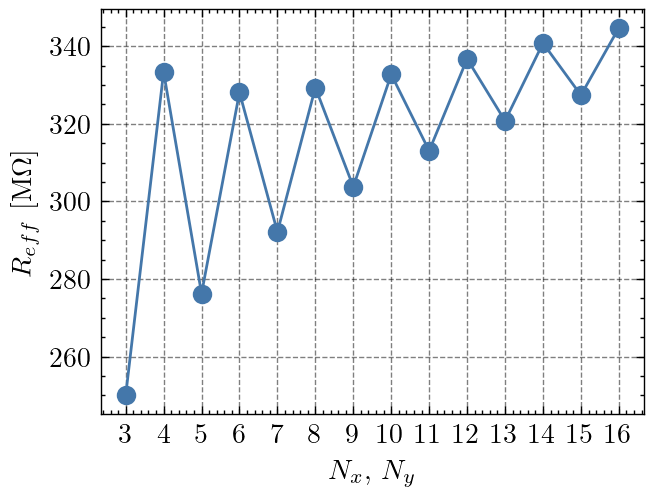

In [190]:
fig, ax = plt.subplots(dpi=200)
ax.plot(df[0],df[1]*1e-6,'-o')
ax.set_ylabel('$R_{eff}$ [M$\Omega$]')
ax.set_xlabel('$N_x$, $N_y$')
_ = ax.set_xticks(N_vals)

In [179]:
def one_over_N(N,a,b,c):
    return a/(N-b) + c

p,_ = curve_fit(one_over_N, df[0].values, df[2].values)
p

array([ 4.11050819e-08, -5.53950101e+00,  1.62053375e-09])

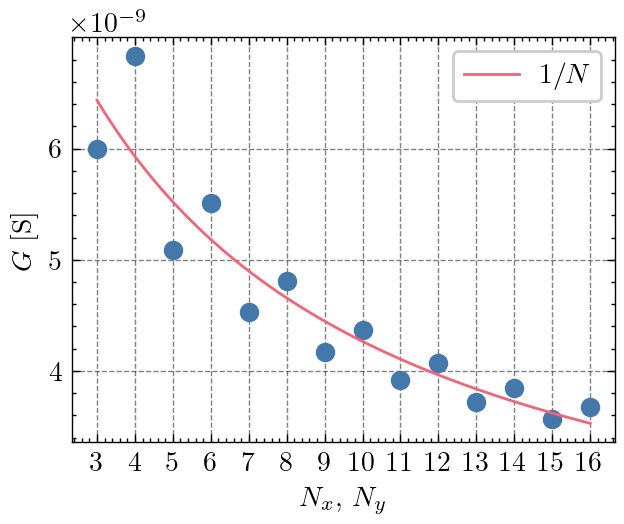

In [191]:
x_val   = np.linspace(N_vals[0],N_vals[-1],1000,endpoint=True)
fig, ax = plt.subplots(dpi=200)
ax.plot(df[0], df[2], 'o')
ax.plot(x_val,one_over_N(x_val,*p),label='$1/N$')
ax.set_ylabel('$G$ [S]')
ax.set_xlabel('$N_x$, $N_y$')
ax.legend()
_ = ax.set_xticks(N_vals)

In [132]:
input_idx       = [1,3]
control_idx     = [0,2,4,5,6]
R_eff_list      = []
C_impact_list   = []

for G in G_list:

    T_in    = G[input_idx] 
    R_eff   = 1 / np.sum(T_in)
    R_eff_list.append(R_eff)

    G_ctl       = G[control_idx]
    C_impact    = G_ctl / np.sum(T_in)
    C_impact_list.append(C_impact)

R_eff_arr       = np.array(R_eff_list)
C_impact_arr    = np.array(C_impact_list)

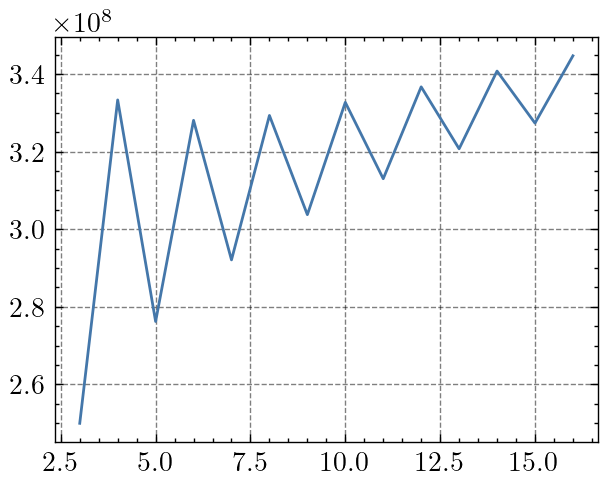

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(N_vals,R_eff_arr)

In [131]:
C_impact_list

[array([0.33333333, 0.66666667, 0.66666667, 1.5       , 1.5       ]),
 array([0.33333333, 0.74074074, 0.74074074, 2.27777778, 2.27777778]),
 array([0.33136305, 0.55420262, 0.55420262, 1.40507152, 1.40507152]),
 array([0.32155065, 0.60629669, 0.60629669, 1.80818212, 1.80818212]),
 array([0.32691022, 0.51183188, 0.51183188, 1.32383265, 1.32383265]),
 array([0.31750433, 0.54903932, 0.54903932, 1.58312694, 1.58312694]),
 array([0.32277289, 0.4886766 , 0.4886766 , 1.26708265, 1.26708265]),
 array([0.31480846, 0.516835  , 0.516835  , 1.45416195, 1.45416195]),
 array([0.31933881, 0.47341718, 0.47341718, 1.22583782, 1.22583782]),
 array([0.31265093, 0.4957891 , 0.4957891 , 1.37044112, 1.37044112]),
 array([0.3165188 , 0.46231201, 0.46231201, 1.19433931, 1.19433931]),
 array([0.31083698, 0.48073915, 0.48073915, 1.31129289, 1.31129289]),
 array([0.31417727, 0.45372581, 0.45372581, 1.16929467, 1.16929467]),
 array([0.30927928, 0.46931729, 0.46931729, 1.26695462, 1.26695462])]

(0.1, 5.0)

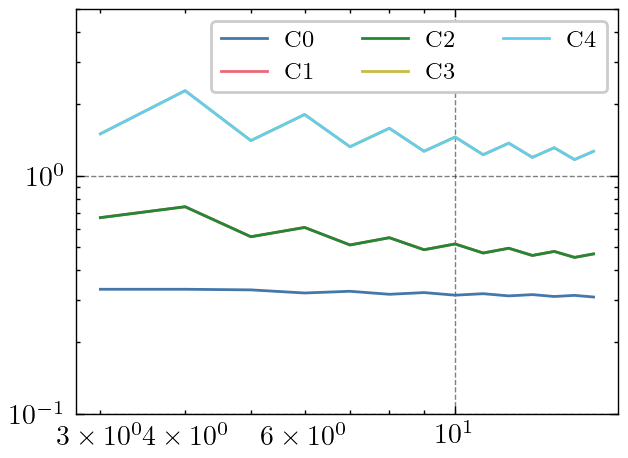

In [144]:
fig, ax = plt.subplots(dpi=200)
for i in range(5):
    ax.plot(N_vals, C_impact_arr[:,i], label=f'C{i}')

ax.legend(fontsize='small',ncol=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-1,5e0)

In [88]:
V_on    = 0.01
I_sat   = T_in.sum() * V_on
dV_C    = 0.30 * abs(I_sat) / max(abs(G_ctl))
print(f"Control voltages: use ±{dV_C*1e3:.1f} mV around 0")

Control voltages: use ±2.0 mV around 0
